In [1]:
!pip install -q mne mne-bids scikit-learn openneuro-py


In [ ]:
from openneuro import download

download(
    dataset="ds004504",
    target_dir="data",
    include=["sub-001"]
)



👋 Hello! This is openneuro-py 2025.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds004504 …


📁 Traversing directories for ds004504 : 8 entities [00:44,  5.60s/ entities]

📥 Retrieving up to 8 files (5 concurrent downloads). 
✅ Finished downloading ds004504.
 
🧠 Please enjoy your brains.
 


In [7]:
import os

for root, dirs, files in os.walk("data/sub-001"):
    for f in files:
        if f.endswith((".edf", ".set", ".vhdr", ".fif")):
            print(os.path.join(root, f))


data/sub-001\eeg\sub-001_task-eyesclosed_eeg.set


In [8]:
from mne_bids import get_entity_vals

tasks = get_entity_vals("data", "task")
tasks


['eyesclosed']

In [9]:
import mne
from mne_bids import BIDSPath, read_raw_bids

bids_path = BIDSPath(
    root="data",
    subject="001",
    task=tasks[0],   # automatically uses first task
    datatype="eeg"
)

raw = read_raw_bids(bids_path)
raw


Reading d:\WorkingDir\ABM-R&D\DemandForecast\Deepgramtest\test1\data\sub-001\eeg\sub-001_task-eyesclosed_eeg.set
Reading channel info from data\sub-001\eeg\sub-001_task-eyesclosed_channels.tsv.


C:\Users\abdullahbinmasood\AppData\Local\Temp\5\ipykernel_33560\472125221.py:11: RuntimeWarning: Did not find any events.tsv associated with sub-001_task-eyesclosed.

The search_str was "data\sub-001\**\eeg\sub-001*events.tsv"
  raw = read_raw_bids(bids_path)
C:\Users\abdullahbinmasood\AppData\Local\Temp\5\ipykernel_33560\472125221.py:11: RuntimeWarning: Unable to map the following column(s) to to MNE:
Gender: F
Age: 57
Group: A
MMSE: 16
  raw = read_raw_bids(bids_path)


<RawEEGLAB | sub-001_task-eyesclosed_eeg.set, 19 x 299900 (599.8 s), ~27 KiB, data not loaded>

In [11]:
raw.load_data()
raw.filter(1.0, 40.0)
#raw.inst.filter(1., 40.)
raw.set_eeg_reference("average")


Reading 0 ... 299899  =      0.000 ...   599.798 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEEGLAB | sub-001_task-eyesclosed_eeg.set, 19 x 299900 (599.8 s), ~43.5 MiB, data loaded>

Using matplotlib as 2D backend.


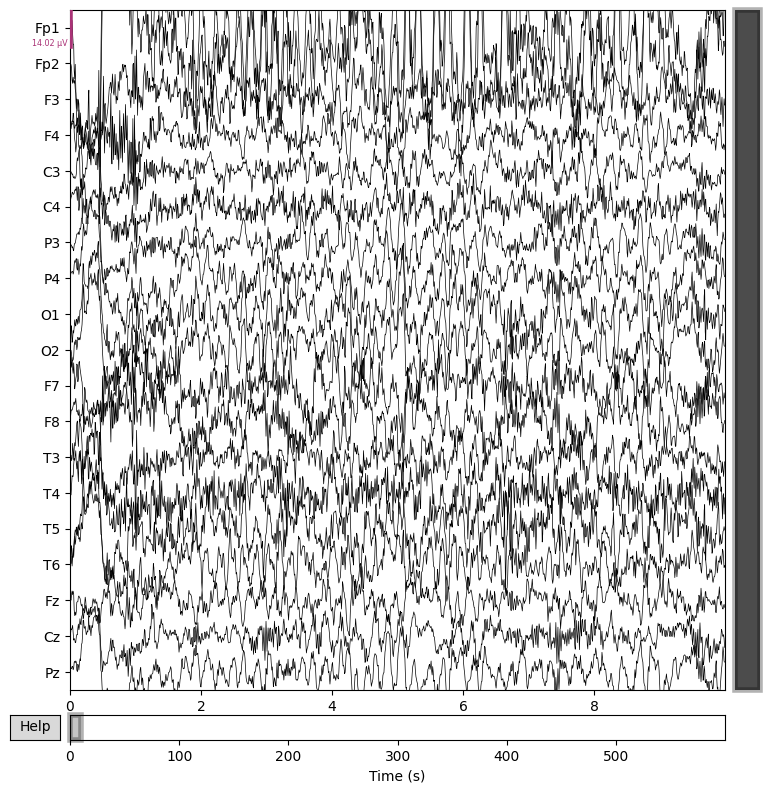

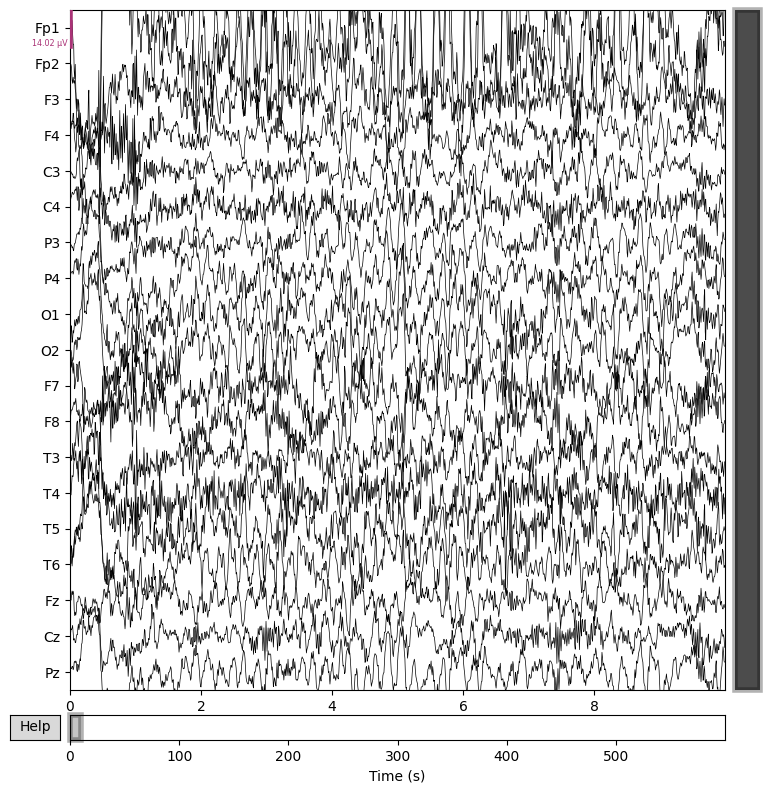

In [12]:
raw.plot(n_channels=20, scalings="auto")


In [13]:
events, event_id = mne.events_from_annotations(raw)

print(event_id)


{}


In [14]:
epochs = mne.make_fixed_length_epochs(
    raw,
    duration=2.0,   # 2-second windows
    overlap=1.0,
    preload=True
)

epochs


Not setting metadata
598 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 598 events and 1000 original time points ...


0 bad epochs dropped


<Epochs | 598 events (all good), 0 – 1.998 s (baseline off), ~86.7 MiB, data loaded,
 '1': 598>

In [15]:
from mne.time_frequency import psd_array_welch
import numpy as np

sfreq = raw.info["sfreq"]
data = epochs.get_data()

bands = {
    "theta": (4, 8),
    "alpha": (8, 13),
    "beta":  (13, 30)
}

features = []

for band, (fmin, fmax) in bands.items():
    psd, freqs = psd_array_welch(
        data,
        sfreq=sfreq,
        fmin=fmin,
        fmax=fmax,
        verbose=False
    )
    band_power = psd.mean(axis=-1)
    features.append(band_power)

X = np.concatenate(features, axis=1)  # shape: epochs × (channels × bands)


In [16]:
y = np.zeros(len(X))
y[len(X)//2:] = 1


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(kernel="linear"))
])

clf.fit(X_train, y_train)


,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('svm', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'


In [18]:
from sklearn.metrics import accuracy_score

y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.84
